# Envelope visualisation
Set the subject identifier and time window, then rerun the parameter cell to display
the selected envelope segment with the sentence mask overlay.


In [1]:

from __future__ import annotations

from pathlib import Path
import json
from typing import Iterable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np

DEFAULT_FS = 100.0

def format_subject_label(subject_argument: str) -> str:
    value = subject_argument.strip()
    if not value:
        raise ValueError("Subject identifier cannot be empty.")
    lower_value = value.lower()
    if lower_value.startswith("sub-"):
        return lower_value
    trimmed = lower_value
    if trimmed.startswith("sub"):
        trimmed = trimmed[3:]
    trimmed = trimmed.lstrip("-_")
    if not trimmed:
        raise ValueError(f"Could not parse subject identifier from '{value}'.")
    try:
        number = int(trimmed)
    except ValueError as exc:
        raise ValueError(f"Subject '{value}' is not numeric.") from exc
    return f"sub-{number:02d}"

def build_subject_paths(subject_label: str) -> Tuple[Path, Path]:
    envelope_dir = (
        Path("derivatives") / "Models" / "envelope" / subject_label / "concatenated"
    )
    envelope_path = envelope_dir / f"{subject_label}_concatenated_envelope_100Hz.npy"
    mask_path = (
        Path("derivatives")
        / "preprocessed"
        / subject_label
        / "concatenated"
        / f"{subject_label}_concatenated_sentence_mask_100Hz.npy"
    )
    return envelope_path, mask_path

def build_word_onsets_path(subject_label: str) -> Path:
    return (
        Path("derivatives")
        / "preprocessed"
        / subject_label
        / "concatenated"
        / f"{subject_label}_concatenated_word_onsets_sec.npy"
    )

def load_array(path: Path, label: str) -> np.ndarray:
    try:
        arr = np.load(path)
    except FileNotFoundError as exc:
        raise FileNotFoundError(f"Could not find {label} file: {path}") from exc
    if arr.ndim != 1:
        raise ValueError(f"Expected 1D {label} array, got shape {arr.shape} from {path}")
    return arr

def validate_window(window: Iterable[float], duration: float) -> Tuple[float, float]:
    start, end = window
    if start >= end:
        raise ValueError("Window start must be smaller than end.")
    if start < 0 or end > duration:
        raise ValueError(
            f"Window {window} falls outside of available duration ({duration:.2f}s)."
        )
    return float(start), float(end)

def mask_regions(mask: np.ndarray, times: np.ndarray) -> List[Tuple[float, float]]:
    mask_bool = mask.astype(bool)
    if not np.any(mask_bool):
        return []
    mask_int = mask_bool.astype(int)
    starts = np.where(np.diff(np.concatenate(([0], mask_int))) == 1)[0]
    ends = np.where(np.diff(np.concatenate((mask_int, [0]))) == -1)[0]
    regions: List[Tuple[float, float]] = []
    dt = times[1] - times[0] if len(times) > 1 else 0.0
    for start_idx, end_idx in zip(starts, ends):
        start_t = times[start_idx]
        end_t = times[min(end_idx, len(times) - 1)] + dt
        regions.append((start_t, end_t))
    return regions

def plot_window(
    envelope: np.ndarray,
    mask: np.ndarray,
    window: Tuple[float, float],
    title: str | None = None,
    word_onsets: np.ndarray | None = None,
) -> plt.Figure:
    fs = DEFAULT_FS
    start, end = window
    start_idx = int(np.floor(start * fs))
    end_idx = int(np.ceil(end * fs))
    time = np.arange(len(envelope)) / fs
    window_time = time[start_idx:end_idx]
    window_env = envelope[start_idx:end_idx]
    window_mask = mask[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(window_time, window_env, label="Envelope", color="tab:blue")
    y_min, y_max = np.nanmin(window_env), np.nanmax(window_env)
    padding = 0.05 * (y_max - y_min if y_max > y_min else 1)
    y_min -= padding
    y_max += padding
    for idx, (region_start, region_end) in enumerate(mask_regions(window_mask, window_time)):
        ax.axvspan(
            region_start,
            region_end,
            color="tab:orange",
            alpha=0.25,
            label="Sentence" if idx == 0 else None,
        )
    if word_onsets is not None:
        word_onsets = np.asarray(word_onsets, dtype=float)
        in_window = word_onsets[(word_onsets >= start) & (word_onsets <= end)]
        for idx, onset in enumerate(in_window):
            ax.axvline(
                onset,
                color="tab:red",
                linestyle="--",
                linewidth=1.2,
                alpha=0.7,
                label="Word onset" if idx == 0 else None,
            )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Envelope amplitude")
    window_title = title or "Envelope window"
    ax.set_title(f"{window_title}: {start:.2f}s to {end:.2f}s")
    ax.set_xlim(start, end)
    ax.set_ylim(y_min, y_max)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.2)
    fig.tight_layout()
    return fig

def visualize_subject_window(subject: str, window: Tuple[float, float], title: str | None = None) -> plt.Figure:
    subject_label = format_subject_label(subject)
    envelope_path, mask_path = build_subject_paths(subject_label)
    envelope = load_array(envelope_path, "envelope")
    mask = load_array(mask_path, "sentence mask")
    if len(envelope) != len(mask):
        raise ValueError("Envelope and mask arrays must be the same length.")
    duration = len(envelope) / DEFAULT_FS
    start, end = validate_window(window, duration)
    fig = plot_window(envelope, mask, (start, end), title=title)
    return fig

def visualize_subject_window_with_word_onsets(
    subject: str,
    window: Tuple[float, float],
    title: str | None = None,
) -> plt.Figure:
    subject_label = format_subject_label(subject)
    envelope_path, mask_path = build_subject_paths(subject_label)
    word_onsets_path = build_word_onsets_path(subject_label)
    envelope = load_array(envelope_path, "envelope")
    mask = load_array(mask_path, "sentence mask")
    word_onsets = load_array(word_onsets_path, "word onsets")
    if len(envelope) != len(mask):
        raise ValueError("Envelope and mask arrays must be the same length.")
    duration = len(envelope) / DEFAULT_FS
    start, end = validate_window(window, duration)
    fig = plot_window(
        envelope,
        mask,
        (start, end),
        title=title,
        word_onsets=word_onsets,
    )
    return fig


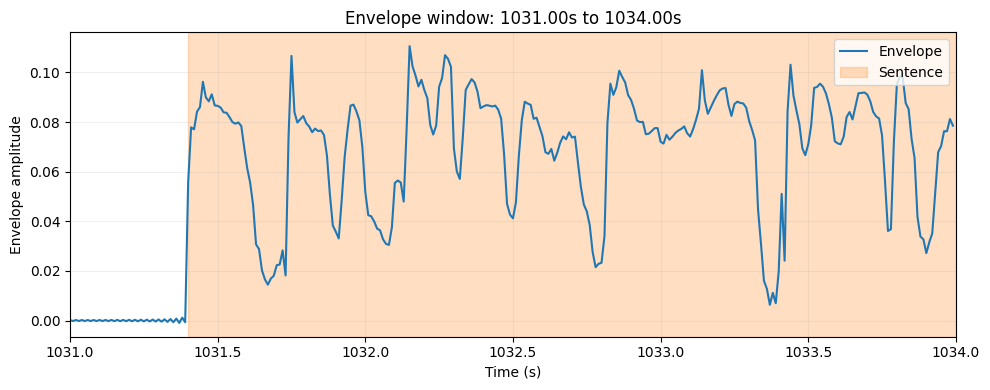

In [6]:

# --- Parameters ---
subject = '1'        # Accepts formats like '1', '01', or 'sub-01'
window = (1031.0, 1034.0)  # Start and end in seconds
analysis_name = 'center_on_onset_overlap'  # Folder inside results/ containing this analysis
title = None         # Optional custom plot title

fig = visualize_subject_window(subject, window, title=title)

In [ ]:
# --- Subsample overlay (per iteration) ---
iteration_to_plot = 0  # zero-based iteration index
line_height_fraction = 0.06  # vertical spacing as a fraction of the envelope range

subject_label = format_subject_label(subject)
analysis_root = Path('results') / analysis_name
metadata_path = analysis_root / 'single_subjects' / f'{subject_label}_res100_correlation_metadata.json'
if not metadata_path.exists():
    raise FileNotFoundError(f'Could not find metadata file for {subject_label}: {metadata_path}')
with metadata_path.open('r') as f:
    metadata = json.load(f)
cache_info = metadata.get('subsample_cache', {})
cache_path_str = cache_info.get('path') or ''
cache_path = Path(cache_path_str) if cache_path_str else None
if cache_path is None:
    raise FileNotFoundError('Metadata does not include a subsample cache path.')
candidate_paths = [cache_path]
if not cache_path.exists():
    cache_parts = cache_path.parts
    if 'meg-masc' in cache_parts:
        tail = Path(*cache_parts[cache_parts.index('meg-masc') + 1:])
        alt_path = Path.cwd() / tail
        candidate_paths.append(alt_path)
        if alt_path.exists():
            cache_path = alt_path
missing_locations = ', '.join(str(p) for p in candidate_paths)
if not cache_path.exists():
    raise FileNotFoundError(f'Could not find subsample cache. Checked: {missing_locations}')

subsample_indices = np.load(cache_path)
print(f'Loaded subsamples {subsample_indices.shape} from {cache_path}')
if iteration_to_plot < 0 or iteration_to_plot >= subsample_indices.shape[0]:
    raise ValueError('iteration_to_plot is out of bounds for the loaded cache')

iteration_windows = np.asarray(subsample_indices[iteration_to_plot])
subsample_tps = iteration_windows.shape[1]
subsample_duration_sec = subsample_tps / DEFAULT_FS

# Ensure we have a figure and axis to draw on
if 'fig' not in globals():
    env_path, mask_path = build_subject_paths(subject_label)
    fig = plot_window(
        envelope=load_array(env_path, 'envelope'),
        mask=load_array(mask_path, 'sentence mask'),
        window=window,
        title=title,
    )
ax = fig.axes[0]

y_min, y_max = ax.get_ylim()
range_height = y_max - y_min if y_max > y_min else 1.0
line_step = line_height_fraction * range_height
baseline = y_min - line_step * 1.5
visible = 0

for idx, window_indices in enumerate(iteration_windows):
    start_idx = int(window_indices[0])
    start_t = start_idx / DEFAULT_FS
    end_t = start_t + subsample_duration_sec
    if end_t < window[0] or start_t > window[1]:
        continue
    mid_t = (start_t + end_t) / 2.0
    y = baseline - visible * line_step
    ax.hlines(
        y=y,
        xmin=start_t,
        xmax=mid_t,
        colors='#9ae6a0',
        linewidth=2.5,
        label='Subsample (first half)' if visible == 0 else None,
    )
    ax.hlines(
        y=y,
        xmin=mid_t,
        xmax=end_t,
        colors='#2e8b57',
        linewidth=2.5,
        label='Subsample (second half)' if visible == 0 else None,
    )
    visible += 1

if visible == 0:
    print('No subsample windows intersect the current envelope window.')
else:
    ax.set_ylim(baseline - line_step * visible, y_max)
    ax.legend(loc='upper right')
fig


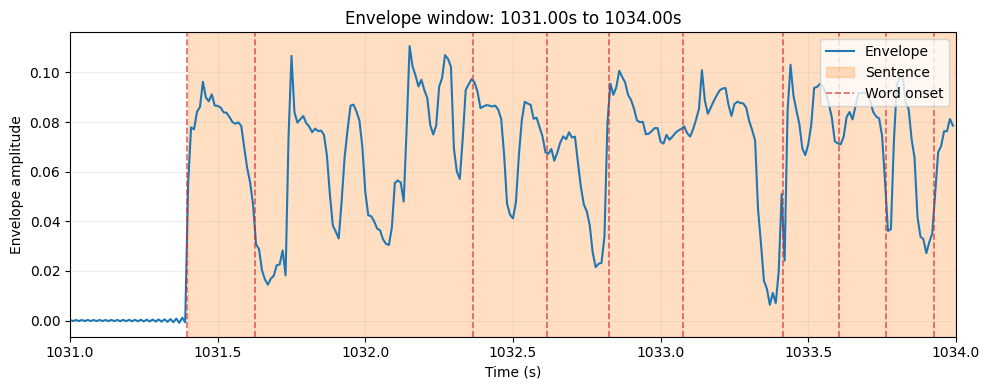

In [5]:

# --- Parameters with word onsets ---
subject = '1'            # Accepts formats like '1', '01', or 'sub-01'
window = (1031.0, 1034.0)  # Start and end in seconds
analysis_name = 'center_on_onset_overlap'  # Folder inside results/ containing this analysis
title = None             # Optional custom plot title

fig_with_onsets = visualize_subject_window_with_word_onsets(subject, window, title=title)
